<a href="https://colab.research.google.com/github/ktasha45/2022_cau_oss_hackathon/blob/main/hackathon_team01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임 -> 런타임 연결 해제 및 삭제"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
 *    "런타임 -> 런타임 다시시작"은 클라우드 스토리지에 저장된 모델은 유지됨
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 6시 (단, 발표자료는 12시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2022_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 테스트 데이터 셋 분류 정확도
 *  model.evaluate(x_test, y_test)
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드가 적발될 경우
*  Pre-trained 모델을 사용한 경우 (transfer learning 포함)
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예. 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성 
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from tensorflow import keras
from keras.utils import np_utils
from keras import datasets, layers, models

# 데이터셋 로드 (MNIST, fashion-MNIST, Kujushiji-MNIST, MNIST_corrupted (test only))
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)

train_ds2, test_ds2 = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)
train_ds2['label'] += 10;
test_ds2['label'] += 10;

train_ds3, test_ds3 = tfds.load('kmnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)
train_ds3['label'] += 20;
test_ds3['label'] += 20;

test_ds4 = tfds.load('mnist_corrupted/zigzag', split='test', shuffle_files=False, batch_size=-1)

# 데이터셋 병합 (training: 180,000개, test: 40,000개)
x_train = np.append(np.append(train_ds['image'], train_ds2['image'], 0), train_ds3['image'], 0);
y_train = np.append(np.append(train_ds['label'], train_ds2['label'], 0), train_ds3['label'], 0);

x_test = np.append(np.append(np.append(test_ds['image'], test_ds2['image'], 0), test_ds3['image'], 0), test_ds4['image'], 0);
y_test = np.append(np.append(np.append(test_ds['label'], test_ds2['label'], 0), test_ds3['label'], 0), test_ds4['label'], 0);

# 분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 총 클래스 개수: 30, 입력 데이터 구조: (28, 28, 1)
num_classes = y_train.shape[1]
input_shape = x_train.shape[1:]
print(num_classes, input_shape)

30 (28, 28, 1)


# **2. 데이터 전처리**



In [2]:
from albumentations import *
import cv2

In [3]:
def get_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
        ], p=0.3)
    ], p=p)

In [4]:
def add_noise(image, p=0.5):
    batch_size, row, col, ch = image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean, sigma, (batch_size, row, col, ch))
    gauss = gauss.reshape(batch_size, row, col, ch)
    noisy = image + gauss * p
    return noisy

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(180000, 28, 28, 1)
(180000, 30)
(40000, 28, 28, 1)
(40000, 30)


In [6]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

In [7]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, mode):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.mode=mode
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
				# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = np.asarray([self.x[i] for i in indices])
        batch_y = [self.y[i] for i in indices]

        if self.mode == 'train':
          augmented_batch_x = np.asarray([get_aug()(image=img)['image'] for img in batch_x])
          batch_x = add_noise(augmented_batch_x)
          batch_x = batch_x.astype('float32') / 255.0
          del augmented_batch_x
        else:
          batch_x = batch_x.astype('float32') / 255.0

        return np.asarray(batch_x), np.asarray(batch_y)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.mode == 'train':
            np.random.shuffle(self.indices)


In [8]:
train_loader = Dataloader(x_train, y_train, 64, mode='train')
valid_loader = Dataloader(x_test, y_test, 64, mode='test')

In [9]:
imgs, targets = next(iter(train_loader))
print(imgs.shape)
print(targets.shape)

(64, 28, 28, 1)
(64, 30)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


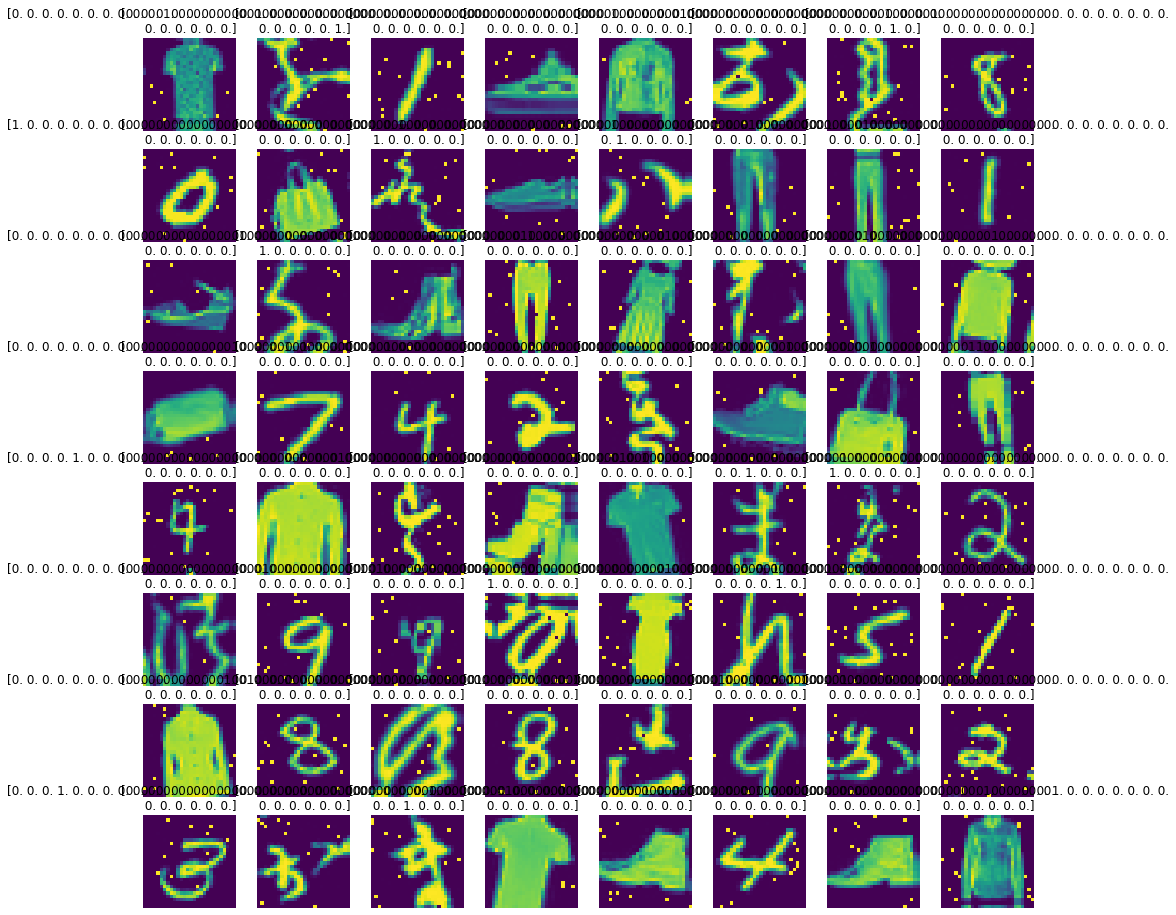

In [10]:
imgs, targets = next(iter(train_loader))

plt.figure(figsize=(16,16))
for i,(img,target) in enumerate(zip(imgs,targets)):
    img = (img.squeeze()*255.0).astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.title(target)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)


# **3. 모델 생성**

In [20]:
input_shape = (28, 28, 1)
model = keras.Sequential()
model.add(keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(128, (3, 3),activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3),activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(30, activation="softmax"))

In [21]:
# model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
#     weights=None,
#     classes=30,
#     classifier_activation="softmax",
#     include_preprocessing=True,
#     input_shape=(32, 32, 1)
# )

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 3)         30        
                                                                 
 batch_normalization_30 (Bat  (None, 28, 28, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_31 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_32 (Bat  (None, 28, 28, 64)      

In [23]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

mc = ModelCheckpoint(
    filepath='/content/checkpoint_entire_best.h5',
    monitor='val_accuracy',
    verbose=1,
    save_weight_only=False,
    save_best_only=True,
    mode='auto')

In [24]:
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecayRestarts(
    0.01,
    1500,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.001,
    name=None
)


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr_decayed_fn), metrics=['accuracy'])

# 체크포인트 생성
cp_callback = [
    mc, es
]


# 모델 트레이닝
# batch_size: 전체 데이터셋 중 몇개씩 학습시킬 것인지
# epoch: 학습에 전체 데이터셋이 총 몇번 이용될 것인지
# shuffle: 학습전에 트레이닝 데이터셋을 랜덤하게 섞을 것인지
# validation_data: 중간 성능 검증에 사용할 data set (x_test1_after, x_test2_after, 혹은 둘을 merge해서 사용)
model.fit(train_loader, validation_data=valid_loader, batch_size=64, epochs = 200, callbacks=[cp_callback])

Epoch 1/200
2813/2813 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.7463
Epoch 1: val_accuracy improved from -inf to 0.43742, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 130s 45ms/step - loss: 0.8159 - accuracy: 0.7463 - val_loss: 3.0511 - val_accuracy: 0.4374
Epoch 2/200
2813/2813 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8942
Epoch 2: val_accuracy improved from 0.43742 to 0.74605, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 127s 45ms/step - loss: 0.3486 - accuracy: 0.8942 - val_loss: 1.4954 - val_accuracy: 0.7461
Epoch 3/200
2813/2813 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.9184
Epoch 3: val_accuracy improved from 0.74605 to 0.80630, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 126s 45ms/step - loss: 0.2717 - accuracy: 0.9184 - val_loss: 0.9781 

# **4. 모델 저장** - 이렇게 하지 않고 checkpoint의 이름을 바꾸는 것으로 저장

In [ ]:
# save_path = '/content/'
# team_name = 'teamXX'

# # 트레이닝된 전체 모델을 저장합니다.
# model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

In [27]:
save_path = '/content/'
team_name = 'team01'

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')

model.evaluate(valid_loader)

625/625 [==============================] - 8s 12ms/step - loss: 0.7411 - accuracy: 0.8617


[0.7410798072814941, 0.8616999983787537]

## TTA

In [28]:
from tqdm import tqdm

tta_steps = 3
count = 0

for (input, target) in tqdm(valid_loader):
  predictions = []
  for i in range(tta_steps):
    batch_x = np.asarray([get_aug()(image=img*255.0)['image'] for img in input])
    batch_x = batch_x / 255.0
    preds = model.predict(batch_x)
    predictions.append(preds)
  pred = np.mean(np.asarray(predictions), axis=0)
  pred = np.argmax(pred, axis=-1)
  count += np.sum(pred==np.argmax(target, axis=-1))

print()
print(count / y_test.shape[0])

100%|██████████| 625/625 [03:10<00:00,  3.27it/s]


0.866575
